# How color is related to sentiment and object in letters

In [13]:
import pandas as pd # library for data analysis
import re
import shutil
import webcolors
import spacy
from spacy import displacy
from collections import Counter
from spacy.matcher import Matcher
from spacy.util import filter_spans 

nlp = spacy.load('en_core_web_sm')

In [14]:
letters = pd.read_csv("letter_raw.csv")
letters.head()

,id,header,content,sketch,from,to,place,date
0,1,"To Theo van Gogh. The Hague, Sunday, 29 Septem...","The Hague, 29 September 1872. My dear Theo, Th...",False,Vincent van Gogh,Theo van Gogh,The Hague,29 September 1872.
1,2,"To Theo van Gogh. The Hague, Friday, 13 Decemb...","The Hague, 13 December 1872. My dear Theo, Tha...",False,Vincent van Gogh,Theo van Gogh,The Hague,13 December 1872.
2,3,"To Theo van Gogh. The Hague, mid-January 1873.","The Hague, January 1873 My dear Theo, I heard ...",False,Vincent van Gogh,Theo van Gogh,The Hague,mid-January 1873.
3,4,"To Theo van Gogh. The Hague, Tuesday, 28 Janua...","The Hague, 28 Jan. 1873 My dear Theo, It’s goo...",False,Vincent van Gogh,Theo van Gogh,The Hague,28 January 1873.
4,5,"To Theo van Gogh. The Hague, Monday, 17 March ...","The Hague, 17 March 1873 My dear Theo, It’s ti...",False,Vincent van Gogh,Theo van Gogh,The Hague,17 March 1873.


In [15]:
# group by year
year = []
for i, row in letters.iterrows():
    if(not row['date'].endswith('.')):
        print(row['id'])
        row['date'] = row['date']+'.'
    if(not row['date'][:-1][-1].isdigit()):
        print(row['id'])
        #letters.drop(row)
    year.append(row['date'][:-1][-4:])
letters['year'] = year

171
530
731
759
848


In [32]:
yearlynum = dict(letters.loc[(letters['from'] == 'Vincent van Gogh')].groupby(['year']).size())
yearlynum

{'1872': 2,
 '1873': 14,
 '1874': 12,
 '1875': 33,
 '1876': 35,
 '1877': 38,
 '1878': 11,
 '1879': 5,
 '1880': 6,
 '1881': 35,
 '1882': 100,
 '1883': 122,
 '1884': 59,
 '1885': 72,
 '1886': 19,
 '1887': 5,
 '1888': 138,
 '1889': 67,
 '1890': 42}

### Construct color list

In [17]:
webcolors.css3_names_to_hex.keys()

dict_keys(['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgrey', 'lightgreen', 'lightpink', 'lightsalmon', 'lights

In [18]:
# construct the list manually from the webcolors and search function on the letter website
# not include words like dark/light/pale, as they are description of color
color_words = ['colour', 'tint', 'purplish', 'yellowish', 'azure', 'black',
              'blue', 'brown', 'crimson', 'gold', 'silver', 'ivory', 'indigo', 'green',
              'grey', 'orange', 'pink', 'purple', 'red', 'violet', 'white', 'yellow',
              'ochre', 'sienna', 'carmine', 'sepia', 'vermilion', 'ultramarine', 'gamboge', 'reddish', 'brownish',
              'cobalt', 'greenish', 'greyish'] 

### Get sentences contain keywords

In [19]:
'''
for each letter, loop over the content sentence by sentence, 
get sentences contain key words
'''
sents_w_keyword = {} #{"year":[(id, sent)]}

for i, row in letters.iterrows():
    if(row['from'] != "Vincent van Gogh"):
        continue
    year = row['year']
    doc = nlp(row.content)
    for sentence in doc.sents:
        sentence = sentence.text
        
        for word in color_words:
            if word in sentence.lower().split():
                if year in sents_w_keyword:
                    sents_w_keyword[year].append((row.id, sentence))
                else:
                    sents_w_keyword[year] = [(row.id, sentence)]
                #sents_w_keyword.append((row.id, sentence))
                break # find one keyword in sentence is enough

In [27]:
sents_w_keyword.keys()

dict_keys(['1873', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890'])

In [25]:
sents_w_keyword['1873']

[(10,
  'The evening hour Slowly the toll of the angelus-bell resounded o’er the fields, As they blissfully bathed in the gold of the evening sun.'),
 (10,
  'The bell, in the grey tower entwined with black-green ivy, Was now silent.'),
 (10,
  'Hanging motionless on high were the brown Sails of the windmill; the leaves stood still and above the huts Blue clouds of peat-smoke ascended so straight from the chimneys That they, too, seemed to hang motionless in the shimmering air. ’'),
 (10,
  'Already the purple and yellow had faded to grey in the west, And in the east there had risen close by the little church the full Copper-coloured disc of the moon, in mist enshrouded, When he entered The Swan, the inn where he boarded.'),
 (11,
  'Slowly the toll of the angelus-bell resounded o’er the fields, As they blissfully bathed in the gold of the evening sun.'),
 (11,
  'The bell, in the grey tower entwined with black-green ivy, Was now silent.'),
 (11,
  'Hanging motionless on high were the 

In [33]:
total_sents = 0
for year in sents_w_keyword:
    total_sents += len(sents_w_keyword[year])
total_sents

1708

In [43]:
years = range(1872, 1891)
freq_by_year = {}
for year in years:
    if str(year) in sents_w_keyword.keys():
        freq_by_year[str(year)] = len(sents_w_keyword[str(year)])/yearlynum[str(year)] #len(set(key for key, value in sents_w_keyword[str(year)]))/yearlynum[str(year)]
    else:
        freq_by_year[str(year)] = 0
freq_by_year

{'1872': 0,
 '1873': 1.0,
 '1874': 0,
 '1875': 0.36363636363636365,
 '1876': 2.4285714285714284,
 '1877': 1.736842105263158,
 '1878': 2.090909090909091,
 '1879': 0.8,
 '1880': 1.3333333333333333,
 '1881': 0.8285714285714286,
 '1882': 1.58,
 '1883': 1.7868852459016393,
 '1884': 1.576271186440678,
 '1885': 3.3194444444444446,
 '1886': 1.1578947368421053,
 '1887': 0.8,
 '1888': 3.282608695652174,
 '1889': 2.9402985074626864,
 '1890': 1.9761904761904763}

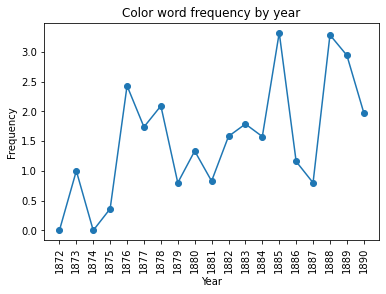

In [80]:
import matplotlib.pylab as plt

ylist = freq_by_year.items()
x, y = zip(*ylist)

plt.plot(x, y, marker='o')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Color word frequency by year')
plt.show()

### NLP

Color words and the objects.

In [59]:
def takeStart(ne):
    return ne[0]
    
# noun phrase: (DET)?(ADJ)*(NOUN)*Noun
#[{"POS":"DET","OP":"?"}, {"POS":"ADJ","OP":"*"}, {"POS":"NOUN","OP":"+"}]  
matcher = Matcher(nlp.vocab)
matcher.add("NP", [[{"POS":"DET","OP":"?"}, {"POS":"ADJ","OP":"*"}, {"POS":"NOUN","OP":"+"}]])


results = {} #{year:[(letter id, colorword, NP)...]} FINAL RESULT

for year in sents_w_keyword.keys():
    results[year] = []
    # for each sentence
    for comp in sents_w_keyword[year]:
        #### first, match the pattern of noun phrase
        letter_id = comp[0]
        doc = nlp(comp[1])
        matches = matcher(doc)
        spans = [doc[start:end] for _, start, end in matches]
        filtered = filter_spans(spans)   

        savedNP = [] #[(start, end, NP)]
        for _, start, end in matches:
            if(doc[start:end] in filtered):
                savedNP.append((start, end, doc[start:end]))

        savedNP.sort(key=takeStart)  


        i = 0
        for ent in doc:
            if ent.text in color_words:
                np_before_dist = 0 # distance to the end of the NP before color word
                np_after_dist = 0 # distance to the start of the NP after color word

                closestNP = None
                beforeNP = None
                afterNP = None
                for np in savedNP:
                    # dont consider if the other color words are recognized as noun
                    if(np[2].text.split(" ")[-1] in color_words):
                        continue
                    # need to consider the situation when the color word is part of the NP! Then it must be an adjective!
                    if(np[0]<=i and np[1]>i and ent.pos_=="ADJ"):
                        closestNP = np[2] # find the NP! break!
                        break

                    before_dist = i-np[1] # distance of color word and the NP before it
                    after_dist = i-np[0] # distance of color word and the NP after it
                    if(before_dist>=0):
                        np_before_dist = before_dist
                        beforeNP = np[2]
                    if(after_dist<0):
                        np_after_dist = after_dist 
                        afterNP = np[2]
                        break # find closest NP after the color word, for loop can be ended

                if(closestNP == None):
                    # compare the distance of NP from before and after the color word
                    if(abs(np_before_dist)>abs(np_after_dist)):
                        closestNP = afterNP
                    else:
                        closestNP = beforeNP

                results[year].append((letter_id, ent, closestNP)) 
            i += 1
    

In [60]:
results

{'1873': [(10, gold, the evening sun),
  (10, grey, tower),
  (10, black, tower),
  (10, green, green ivy),
  (10, brown, the windmill),
  (10, purple, None),
  (10, yellow, None),
  (10, grey, None),
  (11, gold, the evening sun),
  (11, grey, tower),
  (11, black, tower),
  (11, green, green ivy),
  (11, brown, the windmill),
  (11, purple, None),
  (11, yellow, None),
  (11, grey, None),
  (12, green, vallies),
  (12, green, vallies),
  (12, silver, Azure saints),
  (13, blue, blue wallpaper),
  (13, green, a green border),
  (13, black, black pigs),
  (14, black, grave),
  (14, grey, silk),
  (14, grey, sea)],
 '1875': [(30, yellow, a dull yellow sandy road),
  (30, green, huts),
  (30, brown, a grey sky),
  (30, grey, a grey sky),
  (30, white, the horizon),
  (31, brownish, brownish red houses),
  (31, red, brownish red houses),
  (31, grey, grey roofs),
  (31, white, grey roofs),
  (31, yellow, yellow doors),
  (31, white, a large white drawbridge),
  (31, white, white horses),


In [61]:
len(results)

17

In [62]:
total_pairs = 0
for year in results:
    total_pairs += len(results[year])
total_pairs

3634

In [77]:
colors_mentioned_by_year = {} #{year: #words}
for year in range(1872, 1891):
    if(str(year) not in results.keys()):
        colors_mentioned_by_year[str(year)] = 0
        continue
    colors_mentioned_by_year[str(year)] = len(set([color.text for lid, color, obj in results[str(year)]]))
colors_mentioned_by_year

{'1872': 0,
 '1873': 9,
 '1874': 0,
 '1875': 10,
 '1876': 15,
 '1877': 15,
 '1878': 9,
 '1879': 2,
 '1880': 3,
 '1881': 11,
 '1882': 26,
 '1883': 21,
 '1884': 26,
 '1885': 26,
 '1886': 13,
 '1887': 9,
 '1888': 27,
 '1889': 25,
 '1890': 21}

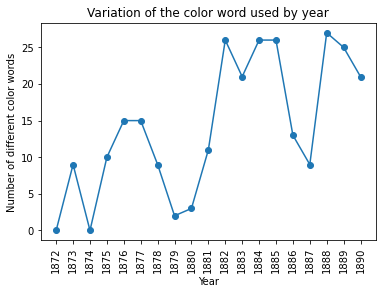

In [81]:
ylist = colors_mentioned_by_year.items()
x, y = zip(*ylist)

plt.plot(x, y, marker='o')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Number of different color words')
plt.title('Variation of the color word used by year')
plt.show()

### Sentiment 

Color words and the sentiment. (ADJ)

In [11]:
def takeStart(ne):
    return ne[0]
    
# adj phrase: (ADJ)+
matcher = Matcher(nlp.vocab)
matcher.add("ADJP", [[{"POS":"ADJ","OP":"+"}]])


results = [] #[(letter id, colorword, ADJP)...] FINAL RESULT


# for each sentence
for comp in sents_w_keyword:
    #### first, match the pattern of noun phrase
    letter_id = comp[0]
    doc = nlp(comp[1])
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    filtered = filter_spans(spans)   

    savedNP = [] #[(start, end, NP)]
    for _, start, end in matches:
        if(doc[start:end] in filtered):
            savedNP.append((start, end, doc[start:end]))

    savedNP.sort(key=takeStart)  
    
    
    i = 0
    for ent in doc:
        if ent.text in color_words:
            np_before_dist = 0 # distance to the end of the NP before color word
            np_after_dist = 0 # distance to the start of the NP after color word

            closestNP = None
            beforeNP = None
            afterNP = None
            for np in savedNP:
                # dont consider if the other color words are recognized as noun
                if(np[2].text.split(" ")[-1] in color_words):
                    continue
                # need to consider the situation when the color word is part of the NP! Then it must be an adjective!
                if(np[0]<=i and np[1]>i and ent.pos_=="ADJ"):
                    closestNP = np[2] # find the NP! break!
                    break

                before_dist = i-np[1] # distance of color word and the NP before it
                after_dist = i-np[0] # distance of color word and the NP after it
                if(before_dist>=0):
                    np_before_dist = before_dist
                    beforeNP = np[2]
                if(after_dist<0):
                    np_after_dist = after_dist 
                    afterNP = np[2]
                    break # find closest NP after the color word, for loop can be ended

            if(closestNP == None):
                # compare the distance of NP from before and after the color word
                if(abs(np_before_dist)>abs(np_after_dist)):
                    closestNP = afterNP
                else:
                    closestNP = beforeNP

            results.append((letter_id, ent, closestNP)) 
        i += 1
    

### Testing

In [55]:
# testing
results = []
sent = '''
with nothing before us except that still, gentle, delicate green and such a light sky
'''
doc = nlp(sent)
matches = matcher(doc)
spans = [doc[start:end] for _, start, end in matches]
filtered = filter_spans(spans)   

savedNP = [] #[(start, end, NP)]
for _, start, end in matches:
    if(doc[start:end] in filtered):
        savedNP.append((start, end, doc[start:end]))

savedNP.sort(key=takeStart)  


i = 0
for ent in doc:
    if ent.text in color_words:
        np_before_dist = 0 # distance to the end of the NP before color word
        np_after_dist = 0 # distance to the start of the NP after color word

        closestNP = None
        beforeNP = None
        afterNP = None
        for np in savedNP:
            # dont consider if the other color words are recognized as noun
            if(np[2].text.split(" ")[-1] in color_words):
                continue
            # need to consider the situation when the color word is part of the NP! Then it must be an adjective!
            if(np[0]<=i and np[1]>i and ent.pos_=="ADJ"):
                closestNP = np[2] # find the NP! break!
                break

            before_dist = i-np[1] # distance of color word and the NP before it
            after_dist = i-np[0] # distance of color word and the NP after it
            if(before_dist>=0):
                np_before_dist = before_dist
                beforeNP = np[2]
            if(after_dist<0):
                np_after_dist = after_dist 
                afterNP = np[2]
                break # find closest NP after the color word, for loop can be ended

        if(closestNP == None):
            print("hiii, keyword is ", ent.text)
            print("the index of the keyword is ", i)
            print(np_before_dist, beforeNP)
            print(np_after_dist, afterNP)
            # compare the distance of NP from before and after the color word
            if(abs(np_before_dist)>abs(np_after_dist)):
                print("the noun after the word is chosen!")
                closestNP = afterNP
            else:
                print("the noun before the word is chosen!")
                closestNP = beforeNP

        results.append((ent, closestNP)) 
    i += 1

hiii, keyword is  green
the index of the keyword is  12
0 None
-3 a light sky
the noun before the word is chosen!


In [56]:
sent

'\nwith nothing before us except that still, gentle, delicate green and such a light sky\n'

In [57]:
for ent in doc:
    print(ent, ent.pos_)


 SPACE
with ADP
nothing PRON
before ADP
us PRON
except SCONJ
that PRON
still ADV
, PUNCT
gentle ADJ
, PUNCT
delicate ADJ
green ADJ
and CCONJ
such DET
a DET
light ADJ
sky NOUN

 SPACE


In [53]:
savedNP

[(1, 3, the houses),
 (5, 7, red roofs),
 (8, 9, windows),
 (10, 11, curtains),
 (16, 19, the grey tower),
 (26, 30, the large grey bridge),
 (31, 33, tall poplars),
 (34, 36, either side),
 (38, 39, people),
 (44, 47, small black figures)]

In [54]:
results

[(red, red roofs),
 (green, curtains),
 (grey, curtains),
 (grey, tall poplars),
 (black, small black figures)]